In [13]:
from cells import layer_v_with_ais_test 
from neuron import h, gui
from helpers.record import *
import numpy as np
import copy
from importlib import reload
from helpers.rheobase import *
from helpers.generic import isolateTime, plotTrace
from helpers.stimulation import *

reload(layer_v_with_ais_test )
cell = layer_v_with_ais_test.SPI6()

# Ap Properties Experiment

Loading the first AP within 15 seconds from pickle

In [14]:
from helpers import storage
trace = storage.unpickleTrace('pickles/SPI6 - Simplified Corticospinal Cell Model - Amp 0.225 first within 15.pickle')

# Plot

Plotting the Results

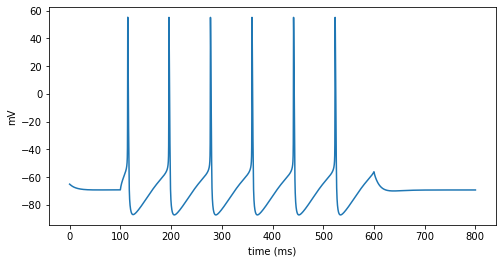

In [15]:
from helpers import generic

generic.plotTrace(trace)

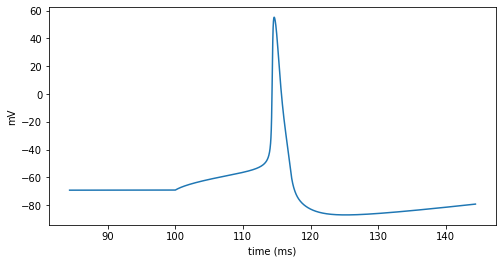

In [24]:

firstpeaktime = trace["aps"][0]
newtrace = generic.isolateTime(trace, firstpeaktime, 30)
generic.plotTrace(newtrace)


# First Derivative

Calculating the Rheobase through iterating until first action potential is generated, This looks like it is wrong

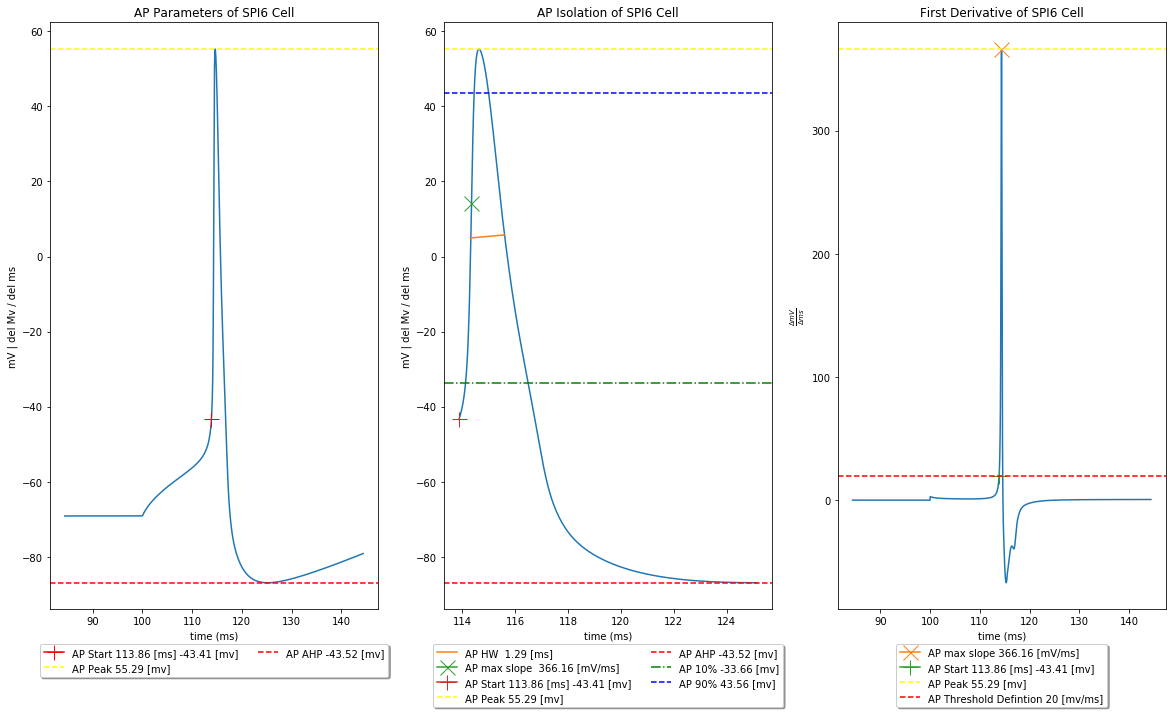

In [155]:
from helpers import ap
reload(ap)
test = ap.calculateAPThresholdAndDerivative(newtrace)
ap.plotApParameters(test, deriv=True)

In [68]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show
from bokeh.models import Span, Label
output_notebook()
p = figure(title="Isolated Ap Trace",
   x_axis_label='ms', y_axis_label='mV'
)
p.line(test["t"],test["v"], color="#00FF00")
#p.line(test["t"],test["v/t"], color="#FF00FF")

def generateCross(p, time, value, color="red", label=""):
    #crossY = Span(location=time, dimension='height', line_color=color, line_width=1)
    crossX = Span(location=value, dimension='width', line_color=color, line_width=1)
    my_label = Label(x=2, y=value, x_units="screen", text= "{:10.2f} mV".format(value) + label)
    p.renderers.extend([crossX])
    p.add_layout(my_label)


generateCross(p, test["peakTime"], test["peakValue"], color="green", label=" Max Amplitude")
generateCross(p, test["firstOver20Time"], test["firstOver20Value"], color="red", label=" Threshold")
generateCross(p, test["hyperMaxTime"], test["hyperMaxValue"], color="yellow", label=" Hyper")
#generateCross(p, test["midApUpTime"], test["midApUpValue"], color="blue", label=" Mid Up")
p.line([test["midApUpTime"],test["midApDownTime"]], [test["midApUpValue"],test["midApDownValue"]])
my_label = Label(x=2, y=34, x_units="screen", text= "{:10.2f} ms".format(test["midApDownTime"]-test["midApUpTime"]) + " AP Half Width")
p.add_layout(my_label)   
show(p)

Loading BokehJS ...

## Plotting of the acquired Traces

With the help of matplotlib

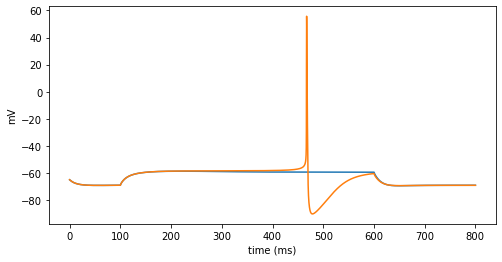

In [23]:
# One Trace
from helpers import generic
reload(generic)
generic.plotTraces([underplot,overplot])

## Calculate the Input Resistance

The input resistance si calculated by measuring the differences of the maximum voltage in the simutlation window to baseline of a 0 amp stimulus of a stimuli ranging from `i*0.1 in range(0,10)` 

In [25]:
from helpers.generic import *

inputresistances = calculateInputResistance(layer_v_with_ais_test.SPI6)
inputresistances.mean()
        

85.81489754460289

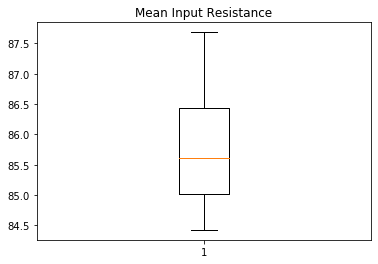